## Notebook for analysis of TIGHT JUNCTION AL

In [1]:
import numpy as np
import torch
import itertools
from active_learner import enable_dropout
from sklearn import metrics
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import rcParams, cycler
import torchvision
import utils
from skimage import io
import pickle
import scipy.stats
import os
import utils, loader
import json
from tqdm import tqdm
from cnn import MICRANet, BayesianMICRANet


from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')
plt.style.use('dark_background')
DEFAULT_COLORS = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
rcParams['axes.prop_cycle'] = cycler(color=DEFAULT_COLORS) 
plt.rcParams['figure.dpi'] = 300
#plt.style.use('default')
#plt.style.use('seaborn-notebook')

/tmp/ipykernel_26245/1594643831.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


### Parameters

In [2]:
#filename = "active_new_dataset"
#filename = "active_by_image_run1"
#filename = "active_multiple_by_image_run2"
filename = "batchbald_run1"
#titles = ['STD', 'BALD', 'Entropy', 'Random']
titles = ['BatchBALD', 'STD', 'BALD', 'Entropy', 'Random']

### Define global functions

In [3]:
def load_model(model_path, repetition, filename, iteration, cuda=True):
    """
    Load a model for testing
    """
    while True:
        try:
            network, optimizer, stats, epoch = utils.load_ckpt(model_path, epoch=iteration, repetition=0, verbose=False, filename=filename)
            break
        except KeyError:
            iteration += 1            
            
    if 'DENN' in model_path:
        model = []
        for i in range(5):
            try:
                m = CNN(False)
                m.load_state_dict(network[f'model_{i}'])
                if cuda:
                    m.cuda()
                m.eval()
                model.append(m)
            except KeyError:
                break
                
    elif 'BatchBALD' in model_path:
        model = BayesianMICRANet(size=64, num_input_images=1, num_classes=1)
        network = network['model_0']
        model.load_state_dict(network)
        if cuda:
            model.cuda()
        model.eval()
    else:
        model = MICRANet(size=64, num_input_images=1, num_classes=1)
        network = network['model_0']
        model.load_state_dict(network)
        if cuda:
            model.cuda()
        model.eval()
        
    return model, stats


def load_acquisition_stats(path, filename, n_rep=5):
    """
    Load active learning stats dict (queried images, STD, entropy)
    """
    stats_dict = {}
    
    for r in range(n_rep):
        stats_dict[r] = np.load(path+'/'+filename+f'_{r+1}_acquisition_stats.npy', allow_pickle=True)[()][0]
    return stats_dict

def test_model(model_path, filename, test_dataset, repetitions=1, save=False, active_stats=None, n_iter=None, cuda=True):
    """
    Test a model over active learning iterations.
    Returns an array of shape (repetitions, iterations, 2, samples) where 2 is for (prediction, label)
    """
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    
    results = []
    for r in range(repetitions):
        results.append([])
        if active_stats:
            iterations = range(len(active_stats[r]))
        elif n_iter:
            iterations = range(n_iter)
        for i in tqdm(iterations):

            model, stats = load_model(model_path, r, filename+f'_{r+1}.hdf5', i, cuda=cuda)
    
            output = [[], []]
            with torch.no_grad():
                for X, y, t, i in test_loader:
                    if cuda:
                        X, y = X.cuda(), y.cuda()

                    if 'DENN' in model_path:
                        pred = torch.cat([m.forward(X).unsqueeze(0) for m in model])
                        pred = torch.mean(pred, dim=0)
                    elif 'BatchBALD' in model_path:
                        pred = model.forward(X, 1)
                        pred = pred[:,0]
                    else:
                        pred = model.forward(X)
                    y = y.squeeze()
                    output[0].extend(pred[:,0].cpu().numpy().tolist())
                    output[1].extend(y.int().cpu().numpy().tolist())
                    
                    del X, y
                del model
                #print(metrics.accuracy_score(y.tolist(), torch.argmax(pred, 1).tolist()))
    
            results[-1].append(output)
    
    results = np.array(results)
    
    if save:
        np.save(model_path + '/' + filename + '_test_output', results)

    return results

def measure_score(results, score_func=metrics.recall_score):
    """
    Calculate the specified score from results from test_model (total + class-wise)
    """
    
    try:
        score_array = np.ndarray(results.shape[0:2])
        
        for rep in range(results.shape[0]):
            for it in range(results.shape[1]):
                truth = results[rep, it, 1]
                pred = results[rep, it, 0] > 0.5
                
                score = score_func(truth, pred)
                score_array[rep, it] = score

    except IndexError: # If number of iterations varies between repeats
        for r in range(len(results)):
            results[r] = np.array(results[r])

        score_array = np.array([np.ndarray(len(results[r])) for r in range(len(results))])
        
        for rep in range(results.shape[0]):
            for it in range(results[rep].shape[0]):
                truth = results[rep, it, 1]
                pred = results[rep, it, 0] > 0.5
                
                score = score_func(truth, pred)
                score_array[rep][it] = score
                
    return score_array

def load_results(path, filename):
    results = np.load(path+'/'+filename+'_test_output.npy', allow_pickle=True)
    return results

def idx_to_class(idx_list, data):
    """
    Convert image indices to their corresponding class
    """
    # classes = data[1][np.isin(data[2], idx_list)]  # not good, doesn't keep order
    indices = []
    for i in idx_list:
        indices.append(np.argmax(data[2] == i))
    classes = data[1][indices]
    return classes

def idx_to_images(idx_list, data):
    """
    Convert image indices to their corresponding class
    """
    # classes = data[1][np.isin(data[2], idx_list)]  # not good, doesn't keep order
    indices = []
    for i in idx_list:
        indices.append(np.argmax(data[2] == i))
    images = data[0][indices]
    return images

def savefig_style(name):
    plt.savefig(name, transparent=True, bbox_inches="tight")

### Load data

In [8]:
#dataset = 'init_image'
dataset = 'fixed_imbalanced'

test_data = utils.split_from_hdf5(f'../../Junction_Dataset/hdf5/{dataset}/testing.hdf5')
test_dataset = loader.CropDataset(test_data[0], test_data[1], test_data[2], test_data[3])

valid_data = utils.split_from_hdf5(f'../../Junction_Dataset/hdf5/{dataset}/validation.hdf5')
valid_dataset = loader.CropDataset(valid_data[0], valid_data[1], valid_data[2], valid_data[3])

pool_data = utils.split_from_hdf5(f'../../Junction_Dataset/hdf5/{dataset}/pool.hdf5')
pool_dataset = loader.CropDataset(pool_data[0], pool_data[1], pool_data[2], pool_data[3])
metadata = pickle.load(open(f'/home/reber199/projects/def-flavielc/reber199/Junction_Dataset/hdf5/{dataset}/pool_meta.pkl', 'rb'))

### Load model results and active learning stats

In [4]:
active_stats = {}
results = {}
valid_results = {}
params = {}

#titles = ['BatchBALD']
for title in titles: 
    print(title)
    #params[title] = np.load('./params/' + filename + '_params.npy', allow_pickle=True)[()]
    with open('./params/' + filename + '_1_params.json', 'r') as fp:
        params[title] = json.load(fp)
    path = f'./models/models_{title}'
    
    active_stats[title] = load_acquisition_stats(path, filename)
    #n_iter = 18
    n_iter = len(active_stats[title][0])
    #print(active_stats[title][0])
    #active_stats[title] = load_acquisition_stats(path, "full_train_test_full_dataset_2")
    
    try:
        results[title] = load_results(path, filename)
    except FileNotFoundError:
        results[title] = test_model(path, filename, test_dataset, repetitions=5, save=True, active_stats=None, n_iter=n_iter, cuda=True)
    #valid_results[title] = test_model(path, filename, valid_dataset, repetitions=5, save=False, active_stats=None, n_iter=n_iter, cuda=True)

BatchBALD
STD
BALD
Entropy
Random


In [59]:
#results['BatchBALD'] = results['BatchBALD'].tolist()
print(results['BatchBALD'].shape)
print(results['BatchBALD'][0,0,0])
#results['BatchBALD'] = np.array(results['BatchBALD'])
#results['BatchBALD'][:,:,0,0]

(5, 41, 2, 1956)
[0.30976486 0.29284322 0.29969364 ... 0.30818075 0.29947025 0.37599811]


In [11]:
metadata_testing = pickle.load(open('/home/reber199/projects/def-flavielc/reber199/Junction_Dataset/hdf5/new_imbalanced/testing_meta.pkl', 'rb'))
idx = np.array(metadata_testing['idx'])
img = np.array(metadata_testing['img'])
print(img)
#print(np.unique(img))
indices = img == 'F2198_s4_pic2_cldn3_factin_40X_z4_MIP.tif'
#indices = img == 'Fctrl2178j_s4_cldn3[green]_Factin[red]_40X_pic1.tif'

for title in titles:
    results[title] = results[title][:,:,:,indices]
    print(results[title].shape)


['F2198_s4_pic2_cldn3_factin_40X_z4_MIP.tif'
 'F2198_s4_pic2_cldn3_factin_40X_z4_MIP.tif'
 'F2198_s4_pic2_cldn3_factin_40X_z4_MIP.tif' ...
 'Fctrl2178j_s4_cldn3[green]_Factin[red]_40X_pic1.tif'
 'Fctrl2178j_s4_cldn3[green]_Factin[red]_40X_pic1.tif'
 'Fctrl2178j_s4_cldn3[green]_Factin[red]_40X_pic1.tif']
(5, 41, 2, 974)
(5, 41, 2, 974)
(5, 41, 2, 974)
(5, 41, 2, 974)


In [56]:
rep = 0
pred = (results['STD'][rep,-1,0,:] > 0.5)*1
label = (results['STD'][rep,-1,1,:] > 0.5)*1

print(results['STD'].shape)
accuracy = metrics.recall_score(label,pred)
print(accuracy)

print(metrics.confusion_matrix(label,pred))

(5, 45, 2, 974)
0.6666666666666666
[[767   6]
 [ 67 134]]


In [35]:
print(np.sum(results['STD'][:,:,0,:] > 05, axis=1))

[[ 5.84432978  8.62949915  7.65445205 ... 10.2564409  11.83290783
   8.84541852]
 [ 6.32700795  8.09578289  6.47897756 ...  7.79669089 11.50173698
   8.94152102]
 [ 7.20775747  7.05143603  7.18426646 ...  7.77013041 12.78228672
  10.21233804]
 [ 4.84532606  6.84909427  5.57386448 ...  8.60607704 10.55640056
   8.02347328]
 [ 6.13795291  6.76074243  6.04952632 ...  7.7279649  10.7859025
   8.23743534]]


### Plot performance by iteration

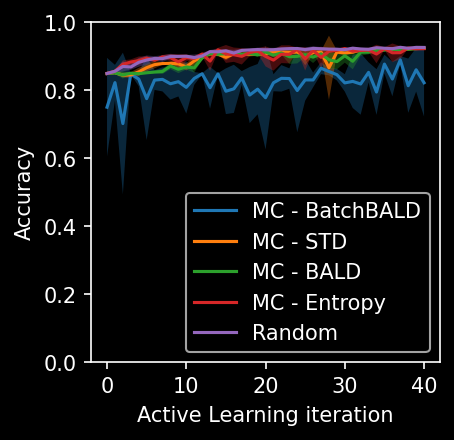

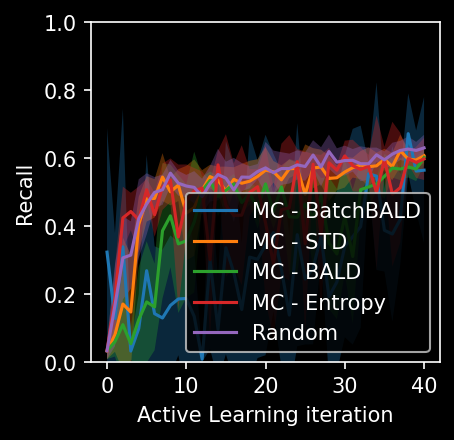

/project/6056509/reber199/active_learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/6056509/reber199/active_learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/6056509/reber199/active_learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/6056509/reber

/project/6056509/reber199/active_learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/6056509/reber199/active_learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/6056509/reber199/active_learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


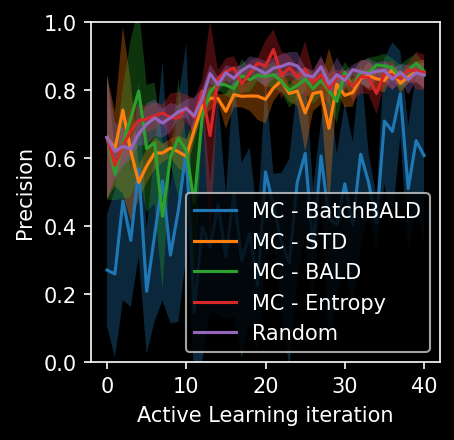

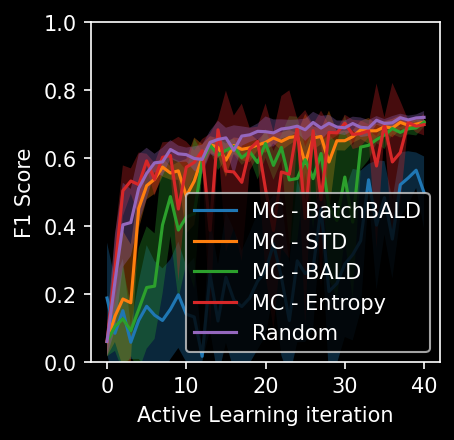

In [5]:
def plot_accuracy_by_iteration(accuracy_array, label, params, ax, inset_ax=None, in_s=0, ymin=0.5, ymax=1.0, ylabel='Accuracy', color=None):
    """
    Plot the accuracy vs active learning iteration
    """
    
    mean_acc = np.mean(accuracy_array, axis=0)
    std_acc = np.std(accuracy_array, axis=0)
    
    x = np.arange(n_iter)
        
    ax.plot(x, mean_acc, label=label, color=color)
    ax.fill_between(x, mean_acc+std_acc, mean_acc-std_acc, alpha=0.33)
    #plt.xticks(np.arange(params['n_init'], params['n_total']+params['n_query'], params['n_query']*4))
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Active Learning iteration')
    ax.set_ylabel(ylabel)
    
    if inset_ax:
        inset_ax.plot(x[in_s:], mean_acc[in_s:], color=color)
        inset_ax.fill_between(x[in_s:], mean_acc[in_s:]+std_acc[in_s:], mean_acc[in_s:]-std_acc[in_s:], alpha=0.33, color=color)
        inset_ax.set_xlim(in_s,len(mean_acc)-1)

scores = [metrics.accuracy_score, metrics.recall_score, metrics.precision_score, metrics.f1_score]
for score, scorename in zip(scores, ['Accuracy', 'Recall', 'Precision', 'F1 Score']):
    fig, ax = plt.subplots()
    fig.set_size_inches(3, 3)
    fig.set_dpi(150)
    #axins = ax.inset_axes([0.40, 0.1, 0.55, 0.50])
    #axins.set_xticks(np.arange(12,50,6))
    #colors = ['tab:blue', 'tab:orange', 'tab:red']
    for title in titles:
        acc_array = measure_score(results[title], score_func=score)
        if title in ['BatchBALD', 'BALD', 'Entropy', 'STD']:
            plot_title = f'MC - {title}'
        else:
            plot_title = title
        plot_accuracy_by_iteration(acc_array, plot_title, params[title], ax, inset_ax=None, in_s=12, ymin=0, ylabel=scorename)

    loc = 'lower right'
    plt.legend(loc=loc)

    savefig_style(f'{scorename}_by_iter.svg')
    plt.show()
    plt.close()

In [23]:
def plot_confusion_matrix(true, pred):
    ax = plt.subplot()
    mat = metrics.confusion_matrix(true, pred)
    ax.matshow(mat, cmap='Blues')
    for (i, j), z in np.ndenumerate(mat):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.xaxis.set_label_position('top') 
    plt.xticks((0,1), labels=('Negative', 'Positive'))
    plt.yticks((0,1), labels=('Negative', 'Positive'))
    
    savefig_style('/home/renaud/plots/conf_matrix.svg')
    plt.show()
    
def show_examples(true, pred):
    tp = np.nonzero(np.logical_and((true == 1), (pred == 1)))[0]
    fp = np.nonzero(np.logical_and((true == 0), (pred == 1)))[0]
    tn = np.nonzero(np.logical_and((true == 0), (pred == 0)))[0]
    fn = np.nonzero(np.logical_and((true == 1), (pred == 0)))[0]
    
    np.random.shuffle(tp)
    np.random.shuffle(fp)
    np.random.shuffle(tn)
    np.random.shuffle(fn)
    
    images = test_data[0][:,0,...]
    
    tp_im = images[tp]/torch.max(images[tp])
    fp_im = images[fp]/torch.max(images[fp])
    tn_im = images[tn]/torch.max(images[tn])
    fn_im = images[fn]/torch.max(images[fn])
    
    print(torch.mean(tn_im), torch.mean(fp_im))
    print(torch.mean(fn_im), torch.mean(tp_im))
    
    top = np.concatenate([tn_im[0], fp_im[0]], axis=1)
    bot = np.concatenate([fn_im[0], tp_im[0]], axis=1)
    mat = np.concatenate([top, bot], axis=0)
    
    ax = plt.subplot()
    ax.imshow(mat, cmap='hot')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    plt.xticks((128,384), labels=('Negative', 'Positive'))
    plt.yticks((128,384), labels=('Negative', 'Positive'))
    
    savefig_style('/home/renaud/plots/conf_matrix_images.svg')
    plt.show()
    
r = 0
it = 0

true = results['Random'][r][it][0]
pred = results['Random'][r][it][1]

show_examples(true, pred)
plot_confusion_matrix(true, pred)

TypeError: max(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

### Plot performance by iteration - Pairwise difference to random

ValueError: too many values to unpack (expected 2)

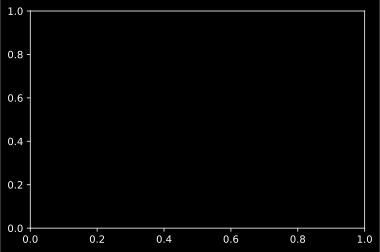

In [34]:

#axins = ax.inset_axes([0.40, 0.1, 0.55, 0.50])
#axins.set_xticks(np.arange(12,50,6))

fig, ax = plt.subplots()
for title in titles:
    if title == 'Random':
        continue

    a_acc_array, a_class_acc_array = measure_accuracy(results[title])
    r_acc_array, r_class_acc_array = measure_accuracy(results['Random'])

    acc_array = a_acc_array - r_acc_array
    if title in ['BALD', 'Entropy', 'STD']:
        plot_title = f'MC - {title}'
    else:
        plot_title = title
    plot_accuracy_by_iteration(acc_array, plot_title, params[title], ax, in_s=12, ymin=-0.1, ymax=0.1)
    

loc = 'upper left'
plt.legend(loc=loc)
plt.axhline(0, linestyle='--')

plt.ylabel('Accuracy vs Random')
savefig_style('/home/renaud/plots/acc_by_iter_pairwise.svg')
plt.show()

### Plot class performance by iteration

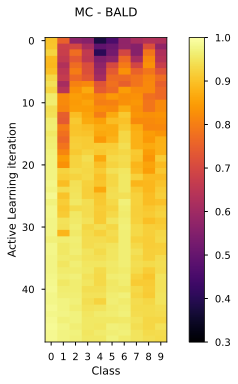

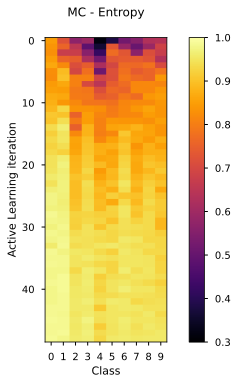

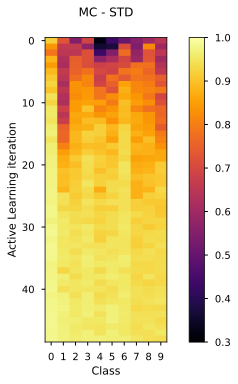

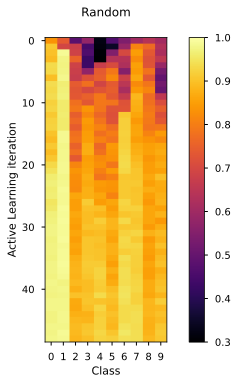

In [8]:
def plot_class_accuracy_by_iteration(accuracy_array, title, params, cmap='Blues', vmin=0.3, vmax=1):
    """
    Plot the class-wise accuracy vs active learning iteration
    """
    mean_acc = np.mean(accuracy_array, axis=0)
    aspect = 0.5 * 50/len(mean_acc)
    ax = plt.subplot(label=title)
    mat = ax.matshow(mean_acc, aspect=aspect, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.xaxis.set_ticks_position('bottom')
    plt.xticks(range(10), range(10))
    plt.ylabel('Active Learning iteration')
    
    #n_iter = params['n_iter']

    #plt.yticks(np.arange(n_iter))
    plt.xlabel('Class')
    plt.title(title)
    plt.colorbar(mat)
    
for title in titles:
    if title in ['BALD', 'Entropy', 'STD']:
        plot_title = 'MC - ' + title
    else:
        plot_title = title
        
    acc_array, class_acc_array = measure_accuracy(results[title])
    plot_class_accuracy_by_iteration(class_acc_array, plot_title, params, cmap='inferno')

    savefig_style(f'/home/renaud/plots/{title}_class_acc.svg')
    plt.show()
    plt.close()
    

### Plot class fairness

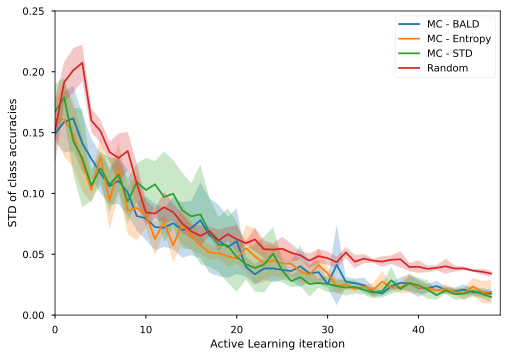

In [9]:
def plot_class_fairness(acc_by_class, params, label):
    """
    Plot the STD of accuracies of classes as a measure of "fairness"
    """
    std = np.std(acc_by_class, axis=2)
    
    try:
        n_iter = len(np.arange(params['n_init'], params['n_total']+params['n_query'], params['n_query']))
        x = np.arange(n_iter)
    except KeyError:
        x = np.arange(params['n_iter'])
        
    plt.plot(x, np.mean(std, axis=0), label=label)
    plt.fill_between(x, 
                     np.mean(std, axis=0)+np.std(std, axis=0),
                     np.mean(std, axis=0)-np.std(std, axis=0),
                     alpha=0.25)

for title in titles:
    acc_array, class_acc_array = measure_accuracy(results[title])
    
    if title in ['BALD', 'Entropy', 'STD']:
        plot_title = f'MC - {title}'
    else:
        plot_title = title
    plot_class_fairness(class_acc_array, params[title], plot_title)
    
    
plt.ylabel('STD of class accuracies')
plt.xlabel('Active Learning iteration')
plt.xlim(0,acc_array.shape[1])
plt.ylim(0, 0.25)
plt.legend()
savefig_style(f'/home/renaud/plots/fairness_by_iteration.svg')


### Plot selected images by class

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


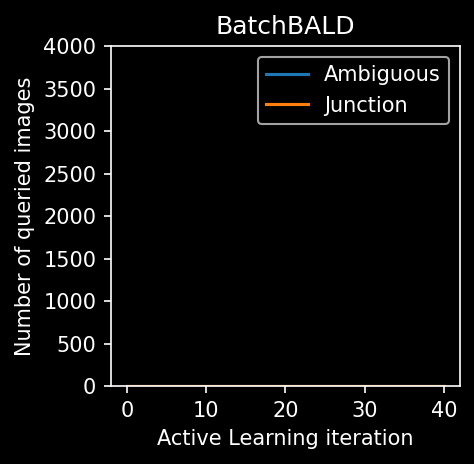

[[43.  7.]
 [44.  6.]
 [42.  8.]
 [41.  9.]
 [38. 12.]]


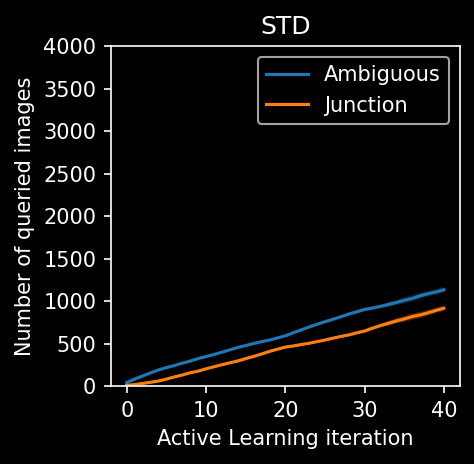

[[47.  3.]
 [46.  4.]
 [48.  2.]
 [46.  4.]
 [45.  5.]]


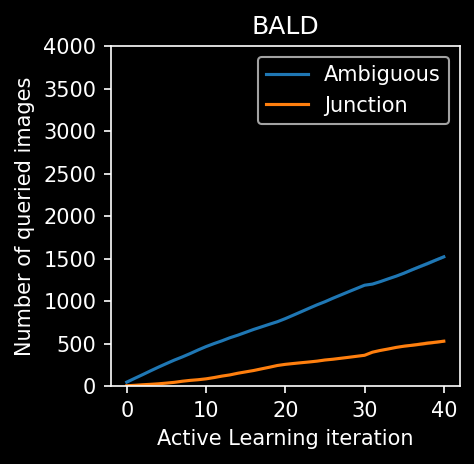

[[42.  8.]
 [43.  7.]
 [48.  2.]
 [42.  8.]
 [35. 15.]]


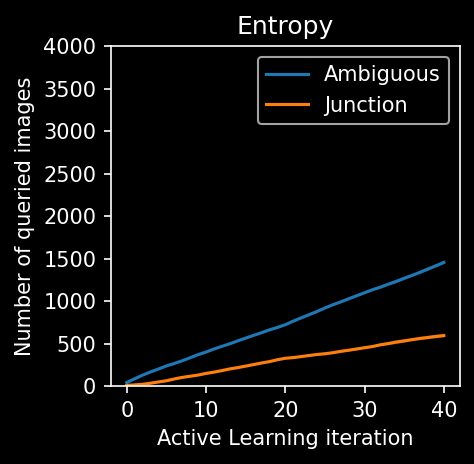

[[47.  3.]
 [46.  4.]
 [48.  2.]
 [46.  4.]
 [47.  3.]]


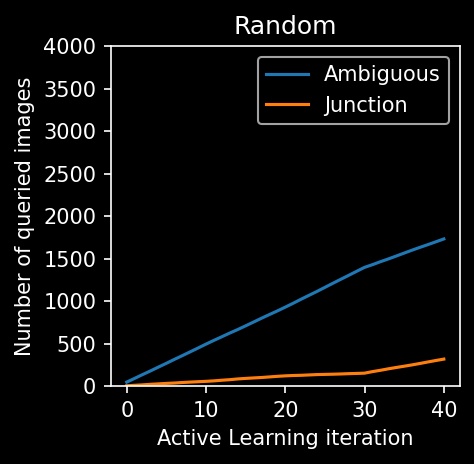

In [6]:
def plot_queried_classes(active_stats, title, params, line=None, class_labels=['Ambiguous', 'Junction'], n_query=200, ymin=0, ymax=300):
    """
    Plot the number of queried images for each class across iterations
    """
    try:
        x = np.arange(params['n_iter'])
    except KeyError:
        pass
        
    count = np.zeros((len(active_stats), len(active_stats[0]),2))
    for r in range(len(active_stats)):
        x = np.arange(len(active_stats[r]))
        for i in range(len(active_stats[r])):
            classes = active_stats[r][i]['Class'][:n_query]
            for c in range(count.shape[2]):
                count[r, i:,c] += np.sum(classes == c) 
    
    print(count[:,0,:])
    std = np.std(count, axis=0)          
    count = np.mean(count, axis=0)        
    plt.figure(figsize=(3,3), dpi=150)
    for c in range(count.shape[1]):
        plt.plot(x, count[:,c], label=class_labels[c])
        plt.fill_between(x, count[:,c]+std[:,c], count[:,c]-std[:,c], alpha=0.25)
    
    if line:
        plt.axvline(line, color='grey', linestyle='--')
    #plt.xticks(x, params['n_total']+1, params['n_query']*4))
    plt.xlabel('Active Learning iteration')
    plt.ylabel('Number of queried images')
    plt.ylim(0, 4000)
    plt.legend()
    plt.title(title)
    
    savefig_style(f'class_selection_{title}.svg')
    plt.show()
    plt.close()

n_query = params['Random']['al_params']['n_query']
for title in titles:
    plot_queried_classes(active_stats[title], title, params[title], ymax=800, n_query=n_query)

### Plot classes proportions?

(2, 4)


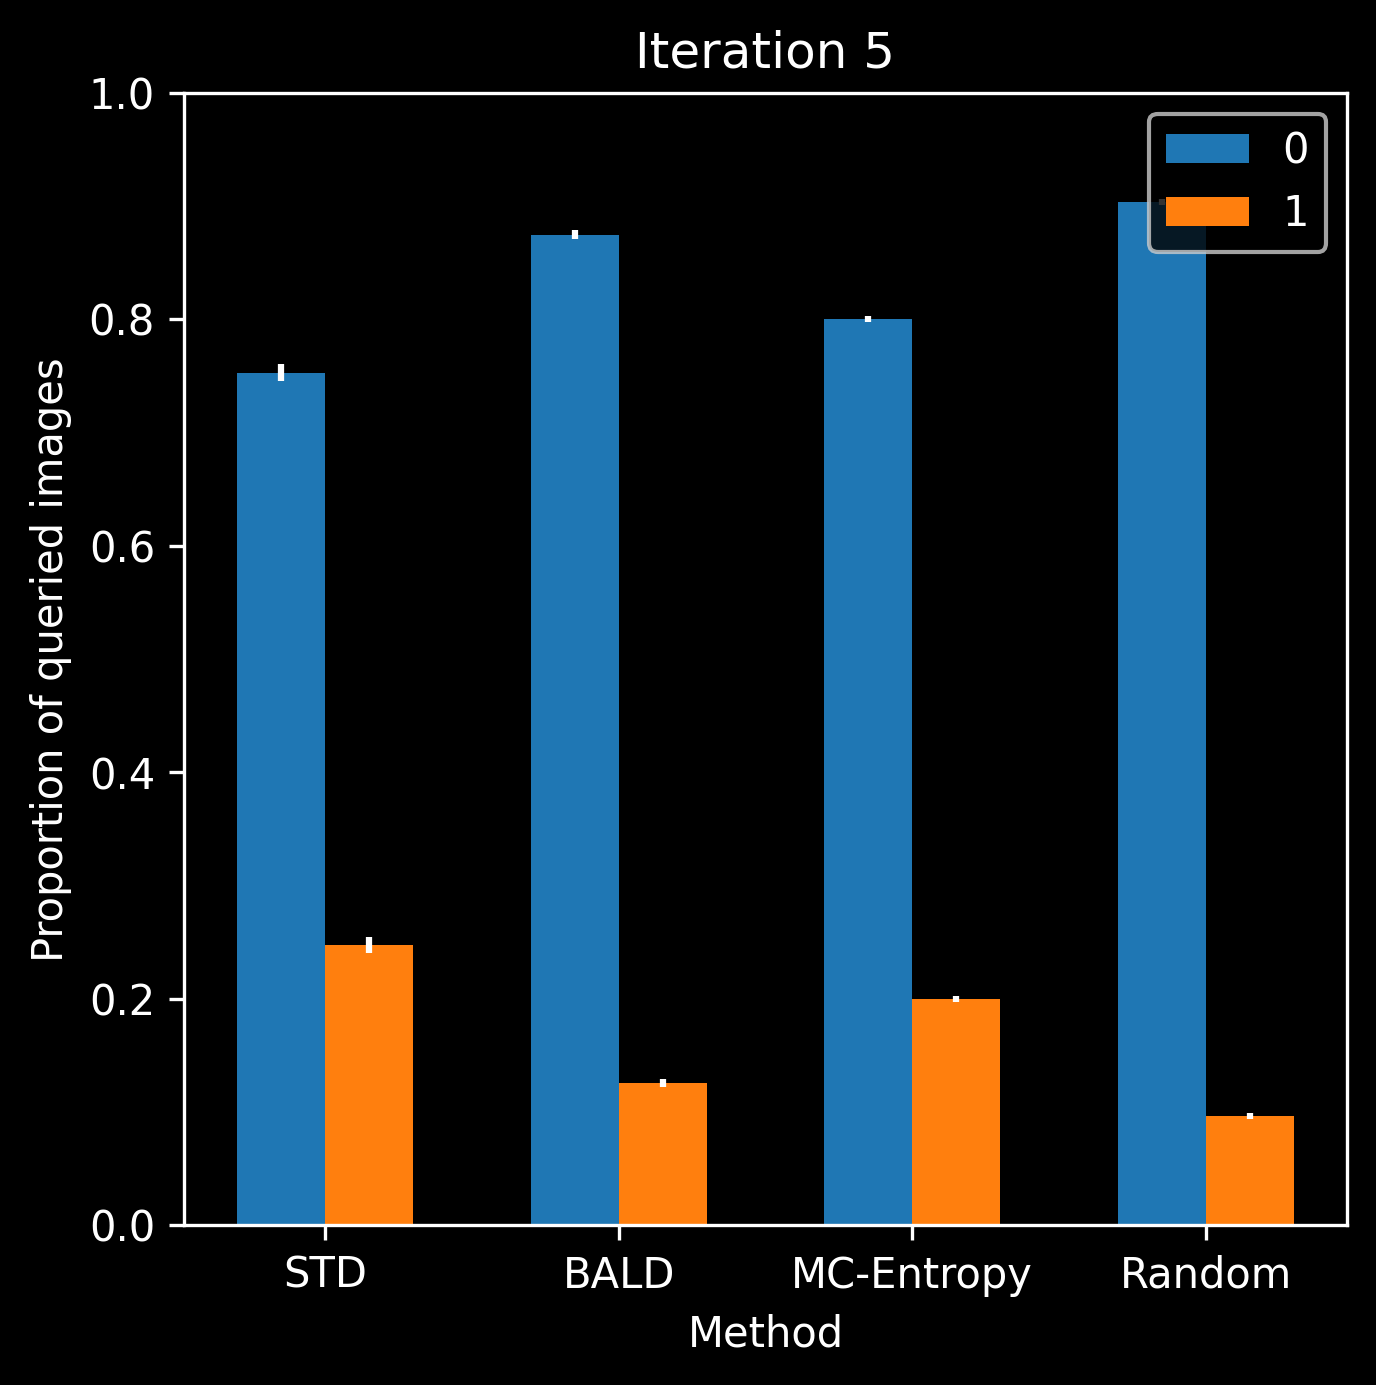

In [15]:
def get_class_proportions(active_stats, title, params, it, line=None, ymin=0, ymax=100, n_query=200):
    """
    Plot the number of queried images for each class across iterations
    """
        
    count = np.zeros((len(active_stats), len(active_stats[0]),2))
    for r in range(len(active_stats)):
        x = np.arange(len(active_stats[r]))
        for i in range(len(active_stats[r])):
            classes = active_stats[r][i]['Class'][:n_query]
            
            for c in range(count.shape[2]):
                count[r, i:,c] += np.sum(classes == c) 
                
    std = np.std(count, axis=0)     
    count = np.mean(count, axis=0)
    
    return count[it,:]/np.sum(count[it]), std[it, :]/np.sum(count[-1])

iterations = [5]
fig, axes = plt.subplots(1, len(iterations), figsize=(5,5))
n_query = params['Random']['al_params']['n_query']

try:
    print(len(axes))
except TypeError:
    axes = [axes]

plot_titles = []
for title in titles:
    if title in ['Entropy']:
        plot_titles.append('MC-' + title)
    else:
        plot_titles.append(title)

for en, (ax, it) in enumerate(zip(axes, iterations)):
    props = np.array([get_class_proportions(active_stats[t], title, params[t], it=it, ymax=150, n_query=n_query)[0] for t in titles])
    stds = np.array([get_class_proportions(active_stats[t], title, params[t], it=it, ymax=150, n_query=n_query)[1] for t in titles])
    props = props.T
    stds = stds.T

    n = len(titles)
    width = 0.3
    pos = np.arange(n) - width/2
    print(props.shape)
    for i, d in enumerate(props):
        ax.bar(pos, d, yerr=stds[i], width=width, label=i, ecolor='white')
        pos = pos + width
    
    if en > 0:
        ax.set_yticklabels([])
    ax.set_xticks(range(n))
    ax.set_xticklabels(plot_titles)
    ax.set_ylim(0, 1.0)
    ax.set_title(f'Iteration {it}')

try:
    axes[1].set_xlabel("Method")
except IndexError:
    axes[0].set_xlabel("Method")
    
axes[0].set_ylabel("Proportion of queried images")
plt.legend(loc='upper right')

savefig_style('class_selection.svg')
plt.show()

### Same thing but break y axis

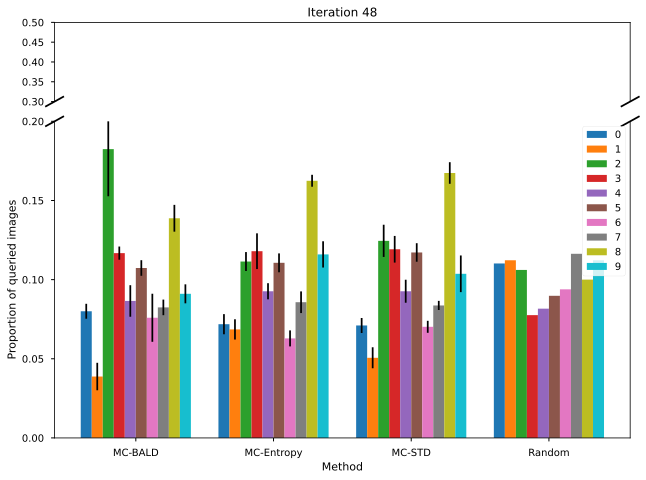

In [12]:
def get_class_proportions(active_stats, data, title, params, it, line=None, ymin=0, ymax=100):
    """
    Plot the number of queried images for each class across iterations
    """
        
    count = np.zeros((len(active_stats), len(active_stats[0]),10))
    for r in range(len(active_stats)):
        x = np.arange(len(active_stats[r]))
        for i in range(len(active_stats[r])):
            if 'Query_all' in active_stats[r][i].keys():
                query_idx = active_stats[r][i]['Query']
            else:
                query_idx = active_stats[r][i]['Query'][:params['n_query']]
            classes = idx_to_class(query_idx, data)
            
            for c in range(count.shape[2]):
                count[r, i:,c] += np.sum(classes == c) 
                
    std = np.std(count, axis=0)     
    count = np.mean(count, axis=0)
    
    return count[it,:]/np.sum(count[it]), std[it, :]/np.sum(count[-1])

iterations = [48]
#fig, (ax1, ax2) = plt.subplots(2, 1, sharex='all')
fig = plt.Figure()
ax1 = plt.axes([1,0.85,1,0.2])
ax2 = plt.axes([1,0,1,0.8])

plot_titles = []
for title in titles:
    if title in ['BALD', 'Entropy', 'STD']:
        plot_titles.append('MC-' + title)
    else:
        plot_titles.append(title)

it=48
props = np.array([get_class_proportions(active_stats[t], pool_data, title, params[t], it=it, ymax=150)[0] for t in titles])
stds = np.array([get_class_proportions(active_stats[t], pool_data, title, params[t], it=it, ymax=150)[1] for t in titles])
props = props.T
stds = stds.T

n = len(titles)
width = 0.08
pos = np.arange(n) - width*4.5
for i, d in enumerate(props):
    ax1.bar(pos, d, yerr=stds[i], width=width, label=i)
    ax2.bar(pos, d, yerr=stds[i], width=width, label=i)
    pos = pos + width

ax2.set_xticks(range(n))
ax2.set_xticklabels(plot_titles)
ax2.set_ylim(0, 0.2)
ax1.set_ylim(0.3, 0.5)
ax1.set_title(f'Iteration {it}')

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel("Method")
ax2.set_ylabel("Proportion of queried images")

ax2.set_yticks(np.arange(0,0.225,0.05))
ax1.set_yticks(np.arange(0.3,0.52,0.05))

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_xticks([])

plt.legend(loc='upper right')

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them

kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d*4, +d*4), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d*4, +d*4), **kwargs)  # top-right diagonal

d = .015
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.subplots_adjust(hspace=0.1)

savefig_style('/home/renaud/plots/class_selection.svg')
plt.show()

### Plot accuracy by cost

(5, 49)
(5, 49)
(5, 49)
(5, 49)


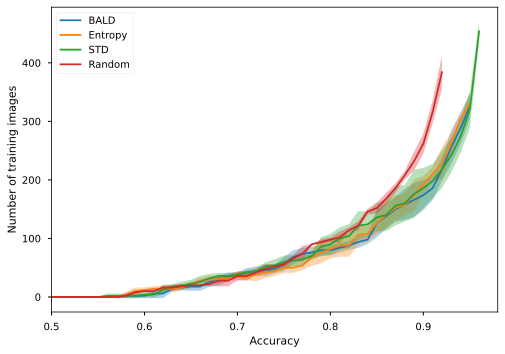

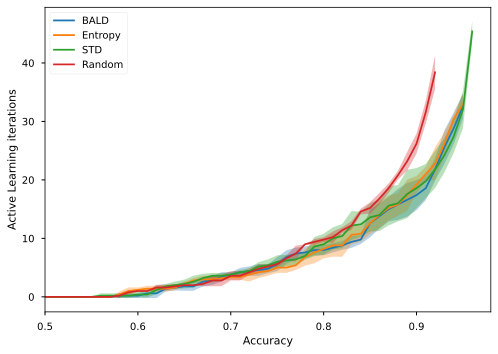

In [13]:
def get_stats_by_accuracy(results, stats, params, acc_range=np.arange(0.5,1.0,0.05)):
    acc_array, class_acc_array = measure_accuracy(results)
    print(acc_array.shape)
    
    cost_list = []
    keys = ["n_images", "iters", "std_n_images"]
    data = {k:np.zeros((acc_array.shape[0], len(acc_range))) for k in keys}
    for k in keys:
        data[k][:] = np.nan
    for i, acc in enumerate(acc_range):
        for r in range(acc_array.shape[0]):
            try:
                min_iter = np.where(acc_array[r] > acc)[0][0]
            except IndexError:
                continue
                
            data['iters'][r,i] = min_iter
            
            if 'Cost_all' in stats[r][min_iter].keys():
                data["n_images"][r,i] = sum([len(stats[r][it]['Query']) for it in range(min_iter)])
            else:
                data["n_images"][r,i] = np.sum([params['n_query'] for _ in range(min_iter)])

    return data

def plot_data(data, key, ylabel, xlabel='Accuracy'):
    for t, d in data.items():
        dmean = np.mean(d[key], axis=0)
        dstd = np.std(d[key], axis=0)
        plt.plot(x , dmean, label=t)
        plt.fill_between(x, dmean + dstd, dmean - dstd, alpha=0.33)
    plt.legend()
    plt.xlim(x[0], x[-1])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    savefig_style(f'/home/renaud/plots/{key}_by_accuracy.svg')
    plt.show()

x = np.arange(0.5,0.99,0.01)

output = {t:get_stats_by_accuracy(results[t], active_stats[t], params[t], acc_range=x) for t in titles}

plot_data(output, 'n_images', 'Number of training images')
plot_data(output, 'iters', 'Active Learning iterations')

### Get examples of selected images

In [ ]:
def get_examples(stats, iteration, n_images, metadata, r=0):
    all_images = np.array(metadata['img'])
    all_idx = np.array(metadata['idx'])

    queried = stats[r][iteration]['Index'][:n_images]
    print(queried)
    images = pool_data[0][np.isin(pool_data[3], queried)][:,0]
    img_names = all_images[np.isin(all_idx, queried)]

    classes = pool_data[1][np.isin(pool_data[3], queried)]
    plt.imshow(np.concatenate([i for i in images], axis=1), cmap='gray')
    plt.yticks([])
    plt.xticks(np.arange(32,64*n_images,64), classes)
    plt.show()
    return images

for t in titles:
    print(t)
    for i in [10]:
        for r in range(5):
            images = get_examples(active_stats[t], i, 10, metadata, r=r)
            for n, im in enumerate(images):
                pass
                #io.imsave(f'/home/renaud/plots/{t}_img_{n}_iter_{i}.tif', (im*255).astype('uint8'))


In [72]:
print(active_stats['BatchBALD'][0][10]['Scores'])

[0.13602677254093154, 0.10575737624147719, 0.06749682684464686, 0.024290560948070472, -0.026481270062902795, -0.08778154546654204, -0.15765923700372597, -0.2398387391601846, -0.335869450467964, -0.4455155112471205, -0.576600741778927, -0.7270852683513438, -0.8986547725725775, -1.0984458322498412, -1.3343270512203211, -1.6074602487021383, -1.9160718690037526, -2.2717365969154755, -2.719004276870468, -3.2390947122753766, -3.844258465612122, -4.567687936934188, -5.408689534562531, -6.4015770254810755, -7.592903639139849, -9.019004152646076, -10.680322332089897, -12.644273968713472, -14.928966070003195, -17.700958237563555, -20.966713869500367, -24.809565415842325, -29.3832465346674, -34.7772314320962, -41.15895705921583, -48.719658224829715, -57.74487523161332, -68.37570479967958, -81.04248525703014, -95.95256911204731, -113.5682079187714, -134.4781755482298, -159.1756507980754, -188.4937969351821, -223.33373355728256, -264.5402336757209, -313.7560372555703, -373.3836107620666, -443.76395